In [1]:
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import numpy as np

mnist = fetch_openml('mnist_784',as_frame=False) # Load MNIST dataset from OpenMl

In [2]:
X, y = mnist.data, mnist.target # Get inputs in X and labels in y
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (70000, 784)
y shape: (70000,)


'5'

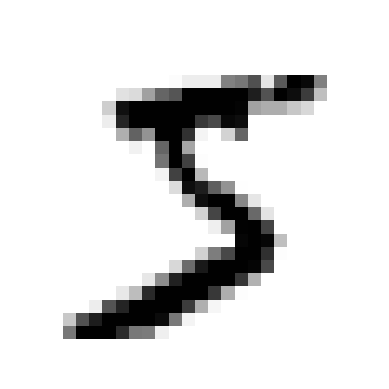

In [3]:
# Function to plot an image from an array 784x1 representing the pixel intensity [0,255] of a 28x28 image. 
# If output = True, then the resized vector is returned
def plot_img(img,output=None):
    img = img.reshape(28,28)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    return img if output  else None
plot_img(X[0,:])
y[0]

In [4]:
# The mnist data set returned by fetch_openml is already divided in training (first 60000 entries) and test (last 10000 entries)
# The training set is already shuffled
X_train, X_test, y_train, y_test = X[:60000,:],X[-10000:,:],y[:60000],y[-10000:]

## First approach

Attempting a binnary classifier to classify as 5 or non-5

In [5]:
y_train_5 = (y_train == '5') # '5' labels are converted to True, and all others to False
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=0)
sgd_classifier.fit(X_train,y_train_5)

SGDClassifier(random_state=0)

In [7]:
sgd_classifier.predict([X[0,:]])

array([False])

## Evaluate performance

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier,X_train,y_train_5,scoring='accuracy',cv=3)

## Testing most frequent classification

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent',random_state=42)
dummy_clf.fit(X_train,y_train_5)
print(any(dummy_clf.predict(X_train)))

In [ ]:
cross_val_score(dummy_clf,X_train,y_train_5,scoring='accuracy',cv=3)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier,X_train,y_train_5,cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5,y_train_pred)
cm

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(f'Precision: {precision_score(y_train_5,y_train_pred)}')
print(f'Recall: {recall_score(y_train_5,y_train_pred)}')

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_classifier,X_train,y_train_5,cv=3,method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [ ]:
plt.plot(thresholds,precisions[:-1],'b--',label='Precision',linewidth=2)
plt.plot(thresholds,recalls[:-1],'g-',label='Recall',linewidth=2)
plt.vlines(3000,0,1.0,'k','dotted',label='threshold')
for idx in range(len(precisions)-1):
    if thresholds[idx] > 2999.5 and thresholds[idx] < 3000.5:
        break
plt.plot(thresholds[idx],precisions[idx],'bo')
plt.plot(thresholds[idx],recalls[idx],'go')
plt.grid(True)
plt.axis(xmin=-50000,xmax=50000)
plt.legend()
plt.show()

In [ ]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path

fig,ax = plt.subplots()
ax.plot(recalls,precisions,linewidth=2,label='Precision/Recall curve')
ax.plot(recalls[idx],precisions[idx],'ko',label='Point at threshold 3000')
arrow = FancyArrowPatch(
    (0.78,0.65), (0.62,0.8), 
    connectionstyle="arc3,rad=0.3",  # Controla la curvatura
    arrowstyle="->", 
    linewidth=2, 
    mutation_scale=20,
    color="black"
)
ax.add_patch(arrow)
ax.vlines(recalls[idx],0,precisions[idx],'k','dotted')
ax.hlines(precisions[idx],0,recalls[idx],'k','dotted')
ax.text(0.52, 0.65 , "Higher\nTreshold", fontsize=12, color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
ax.grid(True)
ax.axis(xmin=0,xmax=1)
ax.legend()
plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5,y_train_pred_90)

In [ ]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

fig,ax = plt.subplots()
ax.plot(fpr,tpr,linewidth=2,label='ROC Curve')
ax.plot([0,1],[0,1],'k:',label="Random clasiffier's ROC curve")
ax.plot([fpr_90],[tpr_90],'ko',label='Threshold for 90% precision')
arrow = FancyArrowPatch(
    (0.19,0.88), (0.07,0.7), 
    connectionstyle="arc3,rad=0.4",  # Controla la curvatura
    arrowstyle="->", 
    linewidth=2, 
    mutation_scale=20,
    color="black"
)
ax.add_patch(arrow)
ax.text(0.15, 0.7 , "Higher\nTreshold", fontsize=12, color="black")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
ax.grid(True)
ax.axis(xmin=0,xmax=1)
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)